## FINAL PROJECT - 02456 DEEP LEARNING
### SEGMENTATION OF CAR PARTS
### COLLABORATION WITH DELOITTE CONSULTING

#### Authors
>*Sanem Leblebici - s222448*

>*Michal Lehwark - s222999*

>*Ari Menachem - s163956*

>*Elli Georgiou - s223408*


## DOWNLOAD EXAMPLE DATA AND DEPENDENCIES

#### PLEASE INSTALL GDOWN WITH THE FOLLOWING COMMAND, IF THIS DOES NOT WORK FOR YOU, YOU CAN DOWNLOAD THE DEPENDENCIES FROM THE LINK BELOW

`pip install gdown`

https://drive.google.com/drive/folders/1eWNuqKkCmW3Mw7gO4jtSoRVqptaeCPXO?usp=sharing


or from dropbox 


https://www.dropbox.com/scl/fi/y5u1a29r8lb87p1q6k6cl/deep_learning_notebook_files.zip?rlkey=ydofzqhxmkgruejptlji1dy4o&dl=0

In case of permission issues contact me directly s222448@dtu.dk

In [1]:
import gdown
import os
import zipfile

def download_and_extract_dropbox_zipped_folder(dropbox_zip_url, destination_folder=None):
    """
    Download a zipped folder from Dropbox using gdown, save it, and extract its contents to the specified folder.

    Parameters:
    - dropbox_zip_url (str): Direct link to the zipped folder in Dropbox.
    - destination_folder (str): Folder where the contents of the ZIP file will be extracted. If None or an empty string, the current working directory is used.
    """
    # Set the destination directory as provided or the current working directory
    destination_folder = destination_folder or os.getcwd()

    # Extract the original filename from the URL
    destination_filename = dropbox_zip_url.split('?')[0].split('/')[-1]

    # Construct the full destination path for the ZIP file
    destination_zip_path = os.path.join(destination_folder, destination_filename)

    # Create destination directory if it doesn't exist
    os.makedirs(destination_folder, exist_ok=True)

    # Download the ZIP file
    gdown.download(dropbox_zip_url, destination_zip_path, quiet=False)

    # Extract the contents of the ZIP file
    with zipfile.ZipFile(destination_zip_path, 'r') as zip_ref:
        zip_ref.extractall(destination_folder)

    # Remove the downloaded ZIP file (optional)
    os.remove(destination_zip_path)
    
# Example usage:
dropbox_file_url = "https://www.dropbox.com/scl/fi/y5u1a29r8lb87p1q6k6cl/deep_learning_notebook_files.zip?rlkey=ydofzqhxmkgruejptlji1dy4o&dl=1"

download_and_extract_dropbox_zipped_folder(dropbox_file_url)

Downloading...
From: https://www.dropbox.com/scl/fi/y5u1a29r8lb87p1q6k6cl/deep_learning_notebook_files.zip?rlkey=ydofzqhxmkgruejptlji1dy4o&dl=1
To: /Users/sanemleblebici/Desktop/deep_learning_project/deep_learning_notebook_files.zip
100%|██████████| 139M/139M [01:54<00:00, 1.21MB/s] 


## IMPORTS

In [2]:
from tqdm import tqdm
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from PIL import Image
import os
import cv2
from typing import Tuple
from torchsummary import summary
from torchvision import transforms as T
from sklearn.metrics import confusion_matrix
from deep_learning_notebook_files.run_results_colab_modules import UNET, UNET_RESNET, DATA_PATH, NUM_EPOCHS, BATCH_SIZE, SPLIT_RATIO, LEARNING_RATE, device, get_data_loaders, pixel_accuracy, save_metric_to_file, num_classes, dice_loss, mean_pixel_accuracy, save_dice_loss_to_file

reduced_data_path = "./deep_learning_notebook_files/reduced_data"
path = "./deep_learning_notebook_files"

2023-12-17 21:02:10.281003: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## TRAINING FUNCTION

In [19]:
def train(true_if_unet_resnet = False, data_dir = "arrays", data_path_colab = reduced_data_path, saveIntermediateModels = False):
    print(device)
    if true_if_unet_resnet:
        model = UNET_RESNET(in_channels=3, out_channels=10)
    else:
        model = UNET(in_channels=3, out_channels=10)

    model.to(device)
    print(summary(model, (3, 256, 256)) )

    for param in model.parameters():
        param.to(device)

    train_dl, val_dl = get_data_loaders(data_dir, data_path_colab, BATCH_SIZE, SPLIT_RATIO)
    optimizer = torch.optim.AdamW(model.parameters(), LEARNING_RATE, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    writer = SummaryWriter()

    train_epoch_losses = []
    val_epoch_losses = []

    if true_if_unet_resnet:
        output_models_dir = "output_models_unet_resnet"
    else:
        output_models_dir = "output_models_unet"
    os.makedirs(output_models_dir, exist_ok=True)

    for epoch in range(NUM_EPOCHS):
        model.train()

        running_loss = 0.0
        for images, masks in tqdm(train_dl, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}"):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, masks)
            loss += dice_loss(torch.nn.functional.softmax(outputs, dim=1).float(),
                              torch.nn.functional.one_hot(masks, num_classes).permute(0, 3, 1, 2).float(),
                              multiclass=True)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        average_loss = running_loss / len(train_dl)
        train_epoch_losses.append(average_loss)
        writer.add_scalar("Loss/train", average_loss, epoch)

        # Validation loop
        model.eval()

        val_loss = 0.0
        with torch.no_grad():
            for images, masks in tqdm(val_dl, desc=f"Validation {epoch + 1}/{NUM_EPOCHS}"):
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                loss += dice_loss(torch.nn.functional.softmax(outputs, dim=1).float(),
                              torch.nn.functional.one_hot(masks, num_classes).permute(0, 3, 1, 2).float(),
                              multiclass=True)
                val_loss += loss.item()

        average_val_loss = val_loss / len(val_dl)
        val_epoch_losses.append(average_val_loss)
        writer.add_scalar("Loss/validation", average_val_loss, epoch)

        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}")

        if saveIntermediateModels:
            # Save the trained model every 10 epochs after the 50th epoch
            if (epoch + 1) % 10 == 0:
                model_save_path = os.path.join("experiment_outputs", output_models_dir, f"unet_model_epoch_{epoch + 1}.pth")
                os.makedirs(os.path.join("experiment_outputs", output_models_dir), exist_ok=True)
                torch.save(model.state_dict(), model_save_path)
                print(f"Model saved at epoch {epoch + 1} to {model_save_path}")

    if not saveIntermediateModels:
        # Save the trained model at the end
        os.makedirs(os.path.join("experiment_outputs", output_models_dir), exist_ok=True)
        torch.save(model.state_dict(), os.path.join("experiment_outputs", output_models_dir, f"unet_model_epoch_{epoch + 1}.pth"))

    # Save the loss data
    data = np.column_stack((np.arange(len(train_epoch_losses)), train_epoch_losses, val_epoch_losses))
    path = os.path.join("experiment_outputs", output_models_dir, "loss_data.txt")
    os.makedirs(os.path.join("experiment_outputs", output_models_dir), exist_ok=True)
    np.savetxt(path, data, header="Index Train_Loss Val_Loss", comments="", fmt="%d %.4f %.4f")
    return path

## START A TRAINING

In [ ]:
train(true_if_unet_resnet = False, data_dir = "arrays", data_path_colab = reduced_data_path, saveIntermediateModels = False)
# Set true_if_unet_resnet True if you will train with resnet enabled UNET, set it to False for original UNET
# Set data_path_colab to the path where folders with data arrays are
# Set data_dir to the name of the folder under the reduced_data_path including the numpy arrays
# Set saveIntermediateModels to True if you want to save every 10 epochs

## LOAD A MODEL WE TRAINED

In [3]:
mdl = UNET()

## If you trained a Resnet model, initialize with that model like commented line below
# mdl = UNET_RESNET(3)

model_name = "unet_model.pth"
model_type = str(type(mdl))

## Can uncomment the next line if your device has gpu
# mdl.load_state_dict(torch.load(path + "/" + model_name, map_location=torch.device('cuda')))

## Can uncomment the next line if your device does not have gpu
mdl.load_state_dict(torch.load(path + "/" + model_name, map_location=torch.device('cpu')))

print(f"{model_type} loaded: {model_name}")

<class 'deep_learning_notebook_files.run_results_colab_modules.UNET'> loaded: unet_model.pth


## TEST LOOP TO GET PREDICTIONS FOR 30 TEST IMAGES SELECTED BY DELOITTE

In [4]:
test_set_path = reduced_data_path + '/test_arrays'
torch.set_printoptions(sci_mode=False)

# Create a list to store the model outputs
model_outputs = []
model_outputs_images = []
model_outputs_gt = []
model_output_pixelAcc = []
filenames_in_order = []

# Set the model to evaluation mode
mdl.eval()

# Define the transformation to be applied to the input images
transform = transforms.Compose([transforms.ToTensor()])
reverse_transform = transforms.Compose([transforms.ToPILImage()])
how_many_images_to_test = 30
index = 0

for filename in os.listdir(test_set_path):
  mask_path = os.path.join(test_set_path, filename)
  mask = np.load(mask_path, allow_pickle=True)


  img = mask[:, :, :3]
  mask_split = mask[:, :, 3]
  mask_split = mask_split.astype(int)
  one_hot_encoded = np.eye(10, dtype=int)[mask_split.squeeze()]
  dice_mask = np.expand_dims(one_hot_encoded.transpose(2,0,1), axis=0)

  img = transform(img)
  img_rev = reverse_transform(img)

  mdl.eval()
 # Make the prediction
  with torch.no_grad():
    img = img.unsqueeze(0)
    print("Predicting for Image " + str(index+1))
    filenames_in_order.append(filename)
    output = mdl(img)
    argmax_output = torch.argmax(output, dim=1)

    # Calculate pixel accuracy
    accuracy = pixel_accuracy(argmax_output[0], torch.tensor(mask_split))
    model_output_pixelAcc.append(accuracy)

  # Store the output in the list
  model_outputs.append(argmax_output[0])
  model_outputs_images.append(img_rev)
  model_outputs_gt.append(torch.tensor(mask_split))

  #detect for first 10 images
  if index == how_many_images_to_test:
    break
  index = index + 1

# The `model_outputs` list now contains the model's output for each test image
# Calculate and print mean pixel accuracy
mean_accuracy = mean_pixel_accuracy(model_outputs, model_outputs_gt)

# Save scores to a file
mean_dice = save_dice_loss_to_file("./dice_scores.txt", model_outputs, model_outputs_gt, filenames_in_order)
print("Dice Scores Per Each Prediction Saved to File " + "dice_scores.txt")
save_metric_to_file("./scores.txt", model_type, model_name, mean_accuracy, mean_dice)
print("Mean Dice and Pixel Accuracy Scores Saved to File " + "scores.txt")

Predicting for Image 1
Predicting for Image 2
Predicting for Image 3
Predicting for Image 4
Predicting for Image 5
Predicting for Image 6
Predicting for Image 7
Predicting for Image 8
Predicting for Image 9
Predicting for Image 10
Predicting for Image 11
Predicting for Image 12
Predicting for Image 13
Predicting for Image 14
Predicting for Image 15
Predicting for Image 16
Predicting for Image 17
Predicting for Image 18
Predicting for Image 19
Predicting for Image 20
Predicting for Image 21
Predicting for Image 22
Predicting for Image 23
Predicting for Image 24
Predicting for Image 25
Predicting for Image 26
Predicting for Image 27
Predicting for Image 28
Predicting for Image 29
Predicting for Image 30
Dice Scores Per Each Prediction Saved to File dice_scores.txt
Mean Dice and Pixel Accuracy Scores Saved to File scores.txt


## PLOTTING LOSS

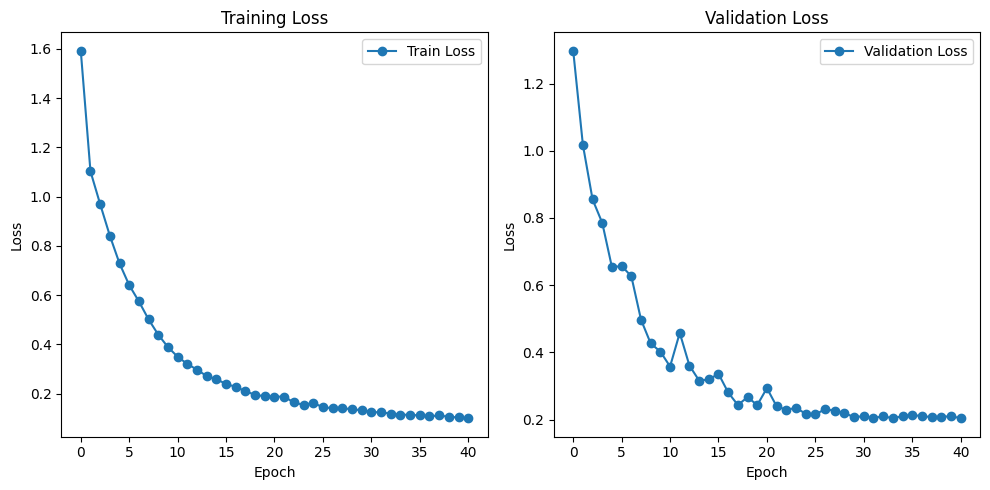

In [5]:
def plot_loss_from_txt(file_path):
    # Read data from the text file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extract data from each line
    indices, train_losses, val_losses = [], [], []
    for line in lines[1:]:  # Assuming the first line contains column headers
        index, train_loss, val_loss = map(float, line.strip().split())
        indices.append(index)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    # Plot the training and validation losses
    plt.figure(figsize=(10, 5))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(indices, train_losses, label='Train Loss', marker='o', linestyle='-')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(indices, val_losses, label='Validation Loss', marker='o', linestyle='-')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

plot_loss_from_txt(path + '/loss_data.txt')

## PLOTTING PREDICTED SEGMENTATION MASKS

photo_0027.npy


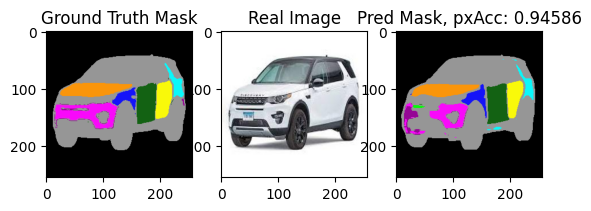

photo_0026.npy


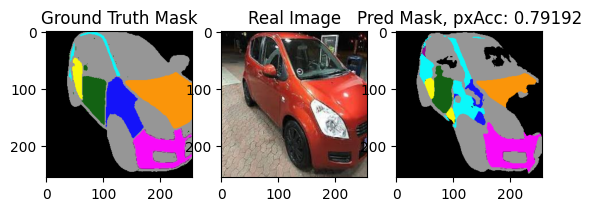

photo_0024.npy


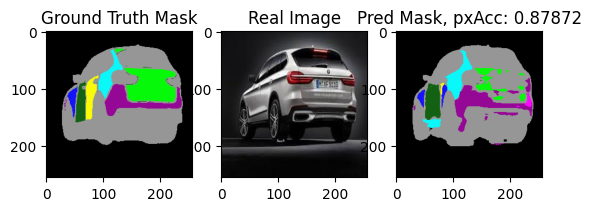

photo_0030.npy


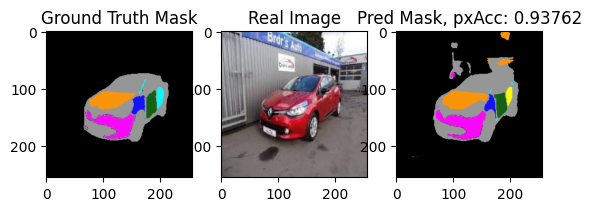

photo_0018.npy


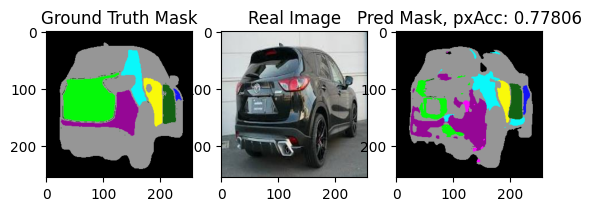

photo_0019.npy


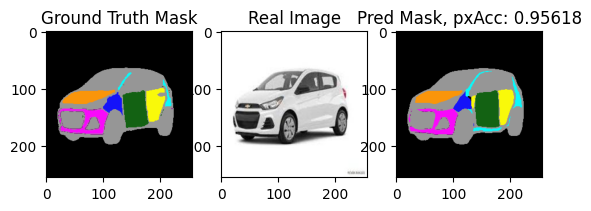

photo_0025.npy


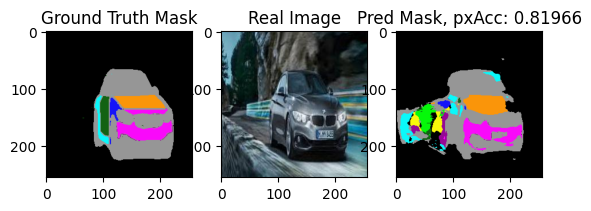

photo_0009.npy


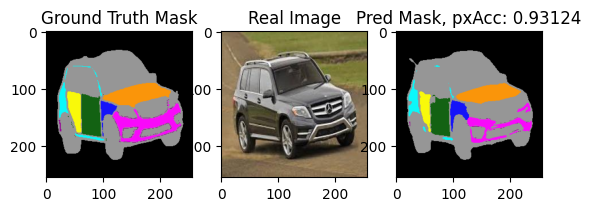

photo_0021.npy


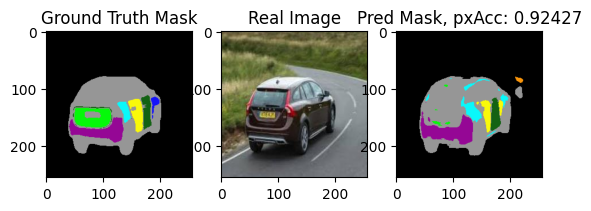

photo_0020.npy


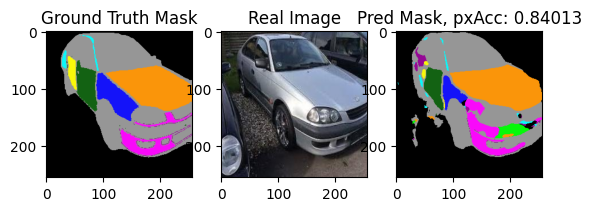

photo_0008.npy


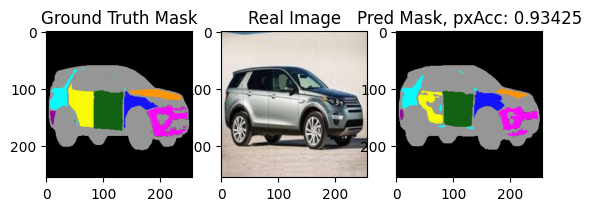

photo_0022.npy


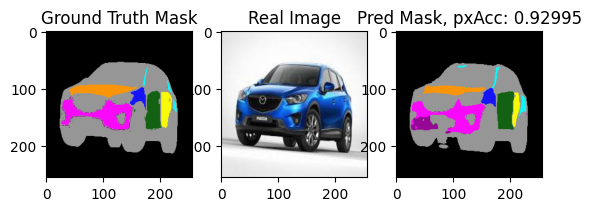

photo_0023.npy


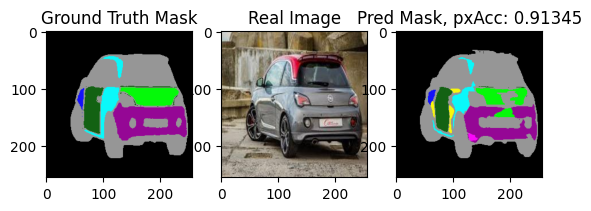

photo_0012.npy


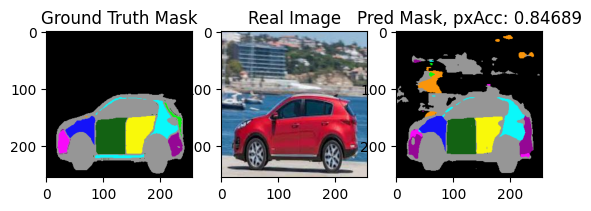

photo_0006.npy


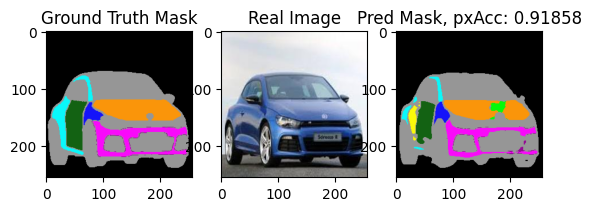

photo_0007.npy


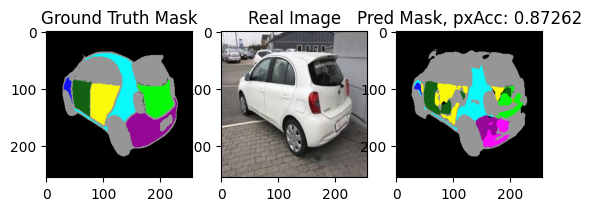

photo_0013.npy


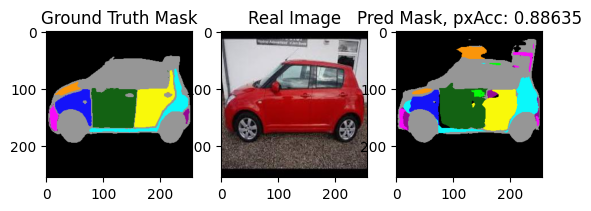

photo_0005.npy


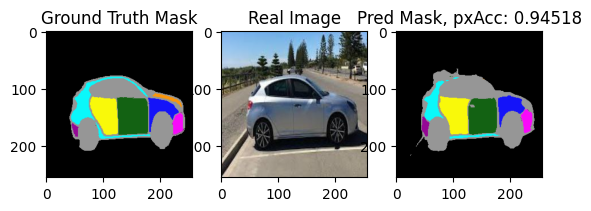

photo_0011.npy


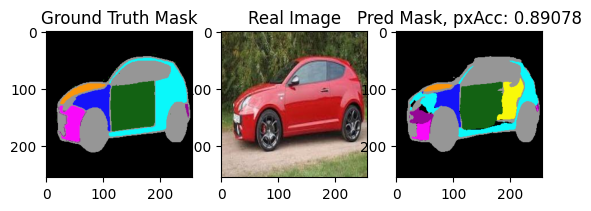

photo_0010.npy


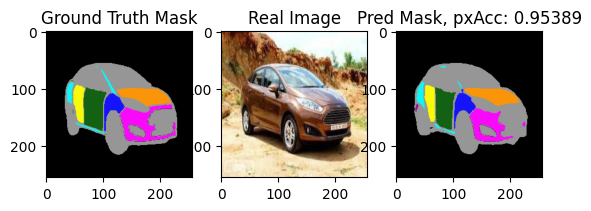

photo_0004.npy


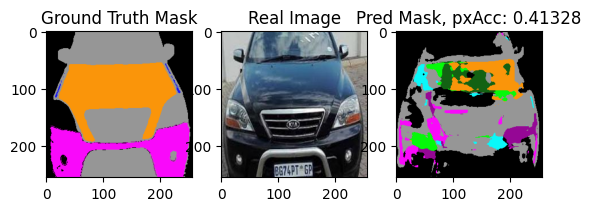

photo_0028.npy


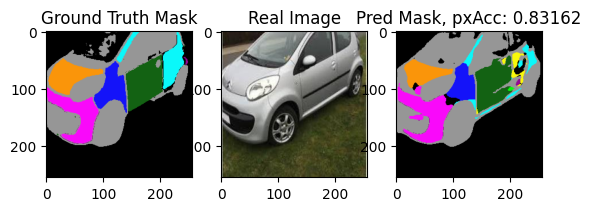

photo_0014.npy


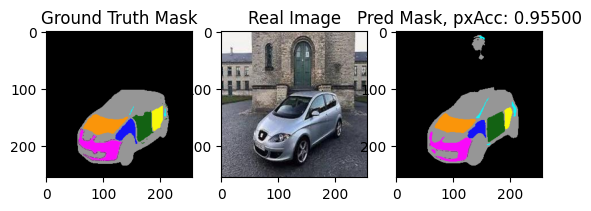

photo_0015.npy


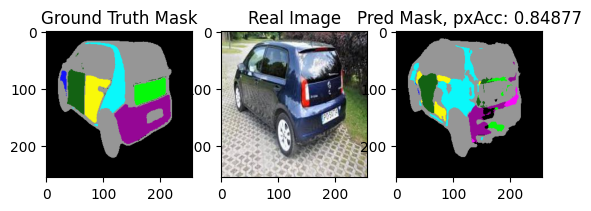

photo_0001.npy


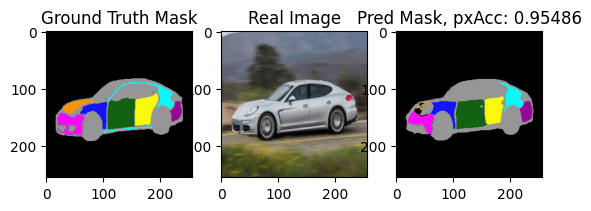

photo_0029.npy


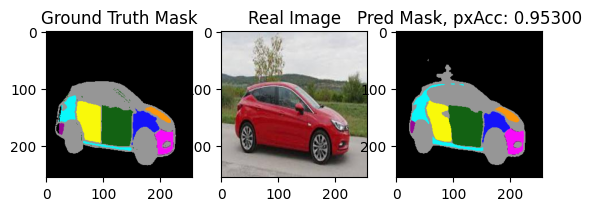

photo_0017.npy


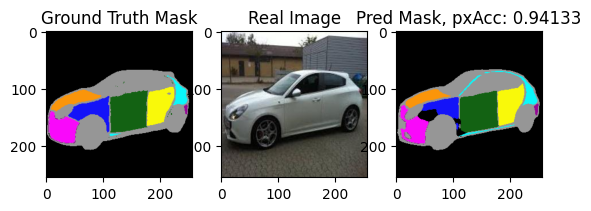

photo_0003.npy


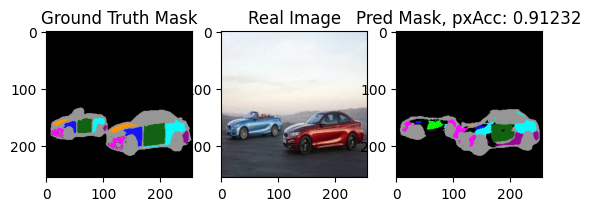

photo_0002.npy


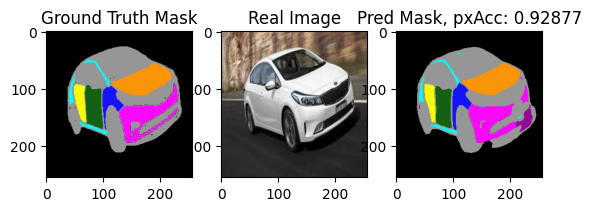

photo_0016.npy


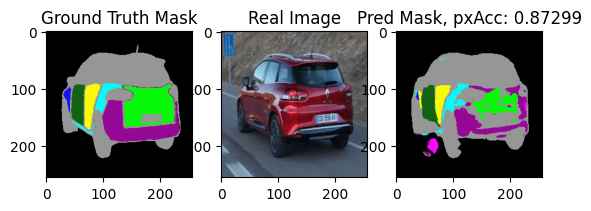

In [7]:
# Define color mapping for each class
color_mapping = {
        0: (0,0,0),
        1: (250, 149, 10),
        2: (19, 98, 19),
        3: (249, 249, 10),
        4: (10, 248, 250),
        5: (149, 7, 149),
        6: (5, 249, 9),
        7: (20, 19, 249),
        8: (249, 9, 250),
        9: (150, 150, 150),
    }

def colorize_segmentation_mask(segmentation_tensor_or_mask, mask = False):
    # Convert the PyTorch tensor to a NumPy array
    if mask == False:
        segmentation_array = segmentation_tensor_or_mask.squeeze(0).cpu().numpy()

    else:
        segmentation_array = segmentation_tensor_or_mask

    # Create a mapping from actual class values to color values
    class_to_color = {class_value: color_mapping[class_value] for class_value in np.unique(segmentation_array)}

    # Create an RGB image with the colored segmentation mask
    colored_mask = np.zeros((256, 256, 3), dtype=np.uint8)
    for class_value, color in class_to_color.items():
        colored_mask[segmentation_array == class_value] = color

    return colored_mask

for image_index_to_display in range(30):
    print(filenames_in_order[image_index_to_display])
    segmentation_tensor = model_outputs[image_index_to_display]
    mask_tensor = model_outputs_gt[image_index_to_display]

    pixel_acc_val = model_output_pixelAcc[image_index_to_display]
    image_tensor = model_outputs_images[image_index_to_display]

    plt.subplot(1, 3, 1)
    plt.imshow(colorize_segmentation_mask(mask_tensor, True))
    plt.title('Ground Truth Mask')

    plt.subplot(1, 3, 2)
    plt.imshow(image_tensor)
    plt.title('Real Image')

    plt.subplot(1, 3, 3)
    plt.imshow(colorize_segmentation_mask(segmentation_tensor))
    plt.title(f"Pred Mask, pxAcc: {pixel_acc_val:.5f}")

    plt.show()